![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from pandas import MultiIndex
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [5]:
# Celda 1
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

In [6]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [7]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [8]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [9]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [10]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [11]:
# Celda 1
# Aplicación de la función tree_grow
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=10, num_pct=10)
tree

{'y_pred': 1,
 'y_prob': 0.5778472913408218,
 'level': 0,
 'split': [1, 51394.909090909096],
 'n_samples': 7031,
 'gain': 0.23630504821132137,
 'sl': {'y_pred': 1,
  'y_prob': 0.8375781948168007,
  'level': 1,
  'split': [0, 2015.0],
  'n_samples': 4474,
  'gain': 0.03713896892744761,
  'sl': {'y_pred': 1,
   'y_prob': 0.6404416839199448,
   'level': 2,
   'split': [0, 2013.0],
   'n_samples': 1447,
   'gain': 0.043426293133466354,
   'sl': {'y_pred': 0,
    'y_prob': 0.2780487804878049,
    'level': 3,
    'split': [0, 2012.0],
    'n_samples': 203,
    'gain': 0.05394731382546758,
    'sl': {'y_pred': 0,
     'y_prob': 0.09195402298850575,
     'level': 4,
     'split': [1, 35652.36363636363],
     'n_samples': 85,
     'gain': 0.01352946029496721,
     'sl': {'y_pred': 0,
      'y_prob': 0.24,
      'level': 5,
      'split': [2, 1.0],
      'n_samples': 23,
      'gain': 0.08132745221592097,
      'sl': {'y_pred': 0,
       'y_prob': 0.15,
       'level': 6,
       'split': [1, 329

In [12]:
classes=['Low Price','High Price']

In [13]:
# Ejecución de función tree_predict
y_predict=tree_predict(X_test, tree)

In [14]:
print("f1 score:",f1_score(y_test, y_predict))
print("accuracy score:",accuracy_score(y_test, y_predict))

f1 score: 0.8961695976873043
accuracy score: 0.8755773672055427


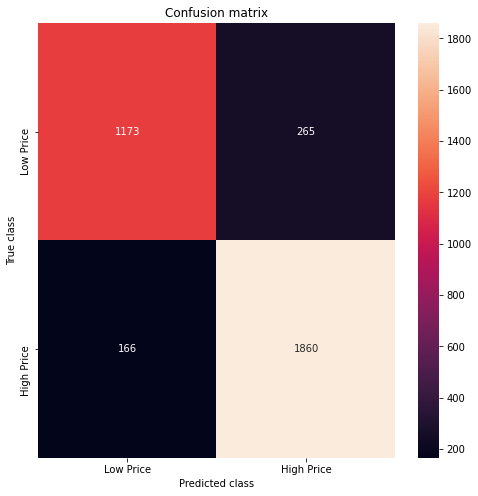

              precision    recall  f1-score   support

           0       0.88      0.82      0.84      1438
           1       0.88      0.92      0.90      2026

    accuracy                           0.88      3464
   macro avg       0.88      0.87      0.87      3464
weighted avg       0.88      0.88      0.87      3464



In [15]:
mostrar_resultados(y_test,y_predict)

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

#### Preparacion de datos

In [16]:
train=data.sample(frac=0.67,random_state=123) #random state is a seed value
test=data.drop(train.index)

X_train = train.drop(['HighPrice'], axis=1)
y_train = train['HighPrice']

X_test = test.drop(['HighPrice'], axis=1)
y_test = test['HighPrice']

#### Creación de 10 muestras de bootstrap 

In [17]:
np.random.seed(123)
n_samples = train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 3454, 1346, ...,   95,  826,  801]),
 array([5657, 6962, 3408, ..., 2882, 6611,  877]),
 array([6412, 1917, 3131, ..., 3896, 2876, 6449]),
 array([6557, 3849, 4565, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 6386, 3108, 2961]),
 array([4357, 3142, 1537, ..., 3088, 4121, 3224]),
 array([6922, 3396, 6588, ..., 3353, 2131, 4627]),
 array([5672, 1289, 3776, ...,  728,  816, 1891]),
 array([6034, 6165, 6079, ..., 6669, 1236, 6177]),
 array([6478, 2225, 5072, ..., 1619,  716, 4589])]

In [18]:
train.iloc[samples[0],:]

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7745,2015,43838,0,0,0,0,1,0,0,1
261809,2015,29166,0,0,0,0,0,1,0,1
85959,2017,18248,0,0,0,0,0,1,0,1
157053,2014,21143,0,0,0,0,0,1,0,1
84654,2015,50605,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
33968,2009,115188,1,0,0,0,0,0,0,0
120229,2014,84650,1,0,0,0,0,0,0,0
206175,2016,43010,0,0,0,0,1,0,0,1
349602,2011,78478,0,1,0,0,0,0,0,0


#### Construcción un árbol de decisión para cada muestra boostrap

In [19]:
# Definición del modelo usando arbol de disicion manual
# DataFrame para guardar las predicciones de cada árbol
y_predict = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
   
    _t=train.iloc[sample]
    X_train = _t.drop(['HighPrice'], axis=1)
    y_train = _t['HighPrice']
    tree2 = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=10, num_pct=10)
    y_predict.iloc[:,i] = tree_predict(X_test,tree2)

In [20]:
y_predict.head(10)

,0,1,2,3,4,5,6,7,8,9
11,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
677,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
756,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
766,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
840,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1300,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1411,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1795,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Impresión de la cantidad de modelos que predijeron 1 para 10 observaciones
y_predict.sum(axis=1)[:10]

11       5.0
677      1.0
756     10.0
766      3.0
840     10.0
1113     1.0
1300    10.0
1368     0.0
1411    10.0
1795     1.0
dtype: float64

#### Votación mayoritaria

In [22]:
y_pred = (y_predict.sum(axis=1) >= (n_B / 2)).astype(np.int)
print(y_pred)
# Desempeño al hacer votación mayoritaria
from sklearn import metrics
metrics.f1_score( y_test,y_pred,)

11        1
677       0
756       1
766       0
840       1
         ..
399583    1
399648    1
399934    0
399951    0
399976    1
Length: 3463, dtype: int64


0.894347722394467

In [23]:
print("f1 score:",metrics.f1_score(y_test,y_pred))
print("accuracy score:",accuracy_score(y_test, y_pred))

f1 score: 0.894347722394467
accuracy score: 0.8720762344787756


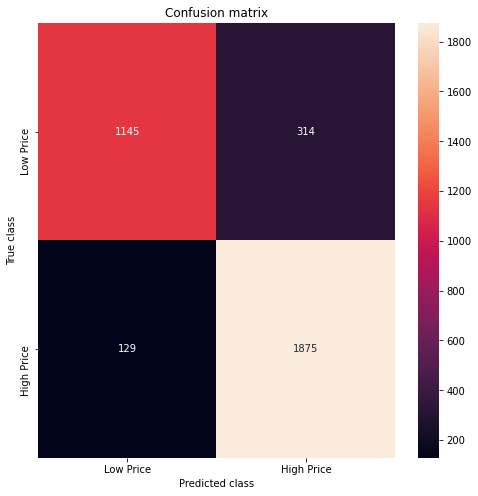

              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1459
           1       0.86      0.94      0.89      2004

    accuracy                           0.87      3463
   macro avg       0.88      0.86      0.87      3463
weighted avg       0.87      0.87      0.87      3463



In [24]:
mostrar_resultados(y_test,y_pred)

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [25]:
bagclf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, max_features=np.log(len(X)+1).astype(int),bootstrap=True, oob_score=True, random_state=1)
bagclf.fit(X_train, y_train)
y_pred = bagclf.predict(X_test)
y_pred
metrics.accuracy_score(y_pred, y_test)

0.8313600924054289

## Comentarios

El resultado de la medida de accuracy sobre el modelo Bagging en un arbol de decisión permite inferir que sin calibrar los parámetros del modelo se obtiene un 83% de predicciones correctas.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [26]:
# Celda 4
# Definición de modelo Random Forest para un problema de clasificación
clf = RandomForestClassifier()
clf.fit(X_train,y_train)


RandomForestClassifier()

In [27]:
#Impresión de desempeño del modelo usando la función cross_val_score  
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.836776
std       0.011429
min       0.816015
25%       0.831308
50%       0.835160
75%       0.846868
max       0.850476
dtype: float64

In [28]:
# Predicciones en el conjunto de prueba
y_pred_test = clf.predict(X_test)

In [29]:
# Revisión de la Precisión en el conjunto de prueba
accuracy_score(y_test, y_pred_test)

0.8313600924054289

In [30]:
print("f1 score:",metrics.f1_score(y_test, y_pred_test))
print("accuracy score:",accuracy_score(y_test, y_pred_test))

f1 score: 0.8539269634817408
accuracy score: 0.8313600924054289


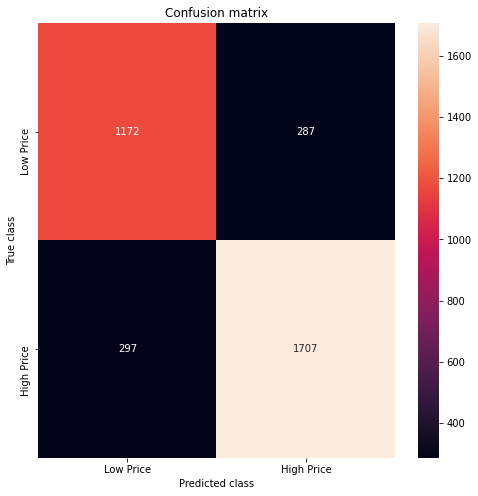

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1459
           1       0.86      0.85      0.85      2004

    accuracy                           0.83      3463
   macro avg       0.83      0.83      0.83      3463
weighted avg       0.83      0.83      0.83      3463



In [31]:
mostrar_resultados(y_test, y_pred_test)

## Comentarios

El resultado de la medida de accuracy sobre el modelo RandomForest ajustado permite inferir que sin calibrar los parámetros del modelo se obtiene un 83% de predicciones correctas.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [32]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
depth_range = range(0, 20, 1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for depth in depth_range:
    clf = RandomForestClassifier(max_depth=depth, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())


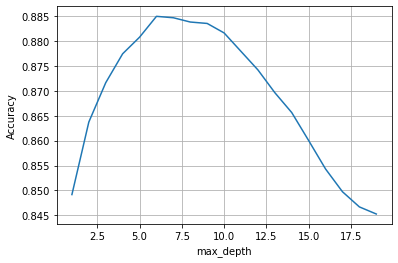

In [33]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.grid(True)

## Calibración n_estimators

In [34]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(0, 1000,100)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(max_depth=6,n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

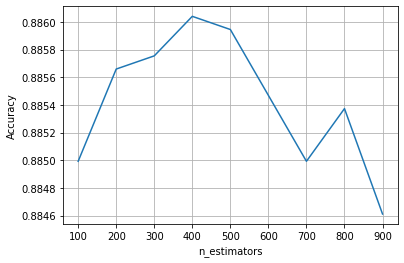

In [35]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.grid(True)

In [36]:
# Selección de variables predictoras
feature_cols = data.columns.drop('HighPrice')
feature_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

In [37]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(max_depth=6,n_estimators=400, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

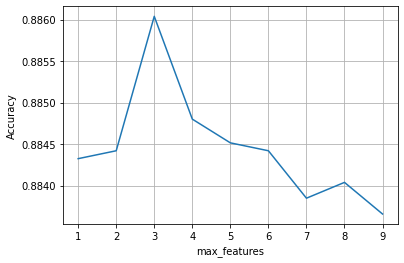

In [38]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.grid(True)

In [39]:
# Definición del modelo con los parámetros max_depth=6, n_estimators=11, max_features=3, random_state=1, n_jobs=-1
clf2 = RandomForestClassifier(max_depth=6, n_estimators=11, max_features=3, random_state=1, n_jobs=-1)
clf2.fit(X_train,y_train)

RandomForestClassifier(max_depth=6, max_features=3, n_estimators=11, n_jobs=-1,
                       random_state=1)

In [40]:
# Make predictions for the test set
y_pred_test2 = clf2.predict(X_test)

In [41]:
# View accuracy score
accuracy_score(y_test, y_pred_test2)

0.872653768408894

In [42]:
# Impresión de resultados de desempeño del modelo
pd.DataFrame({'feature':feature_cols, 'importance':clf2.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.002308
2,M_Camry,0.005009
6,M_CamryLE,0.005208
5,M_CamryL,0.010115
8,M_CamryXLE,0.011432
7,M_CamrySE,0.032907
3,M_Camry4dr,0.078924
0,Year,0.319455
1,Mileage,0.534641


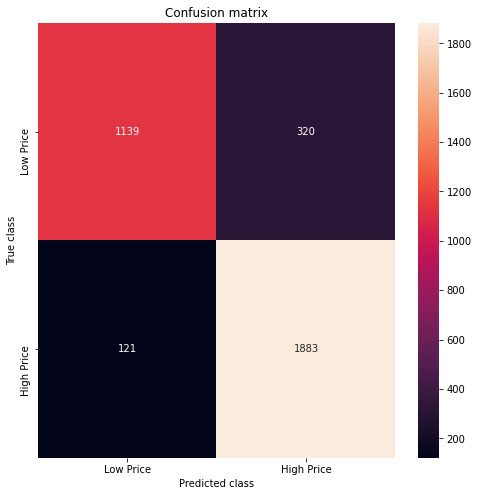

              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1459
           1       0.85      0.94      0.90      2004

    accuracy                           0.87      3463
   macro avg       0.88      0.86      0.87      3463
weighted avg       0.88      0.87      0.87      3463



0.872653768408894

In [50]:
mostrar_resultados(y_test, y_pred_test2)
f1_2=f1_score(y_test, y_pred_test2, average='micro')
f1_2

## Comentarios

Se muestra el accuracy del modelo RandomForest después de entrenado, mejorando con respecto a las medidas obtenidas sin calibrar los parámetros del modelo, con la calibración se obtienen un 87% de predicciones correctas comparando con el modelo sin calibrar que presentaba un 83% de predicciones correctas.

A medida que se va calibrando cada parámetro max_depth, n-estimators y max features se observa que se presenta un mejor desempeño sobre el modelo, incrementandose el accuracy de este.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [43]:
# Celda 6
clf_xgb = XGBClassifier()
clf_xgb

XGBClassifier()

In [44]:
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
clf_xgb.fit(X_train, y_train)
y_pred_xg = clf_xgb.predict(X_test)
metrics.f1_score(y_pred_xg, y_test.values), metrics.accuracy_score(y_pred_xg, y_test.values)

(0.899135446685879, 0.8787178746751372)

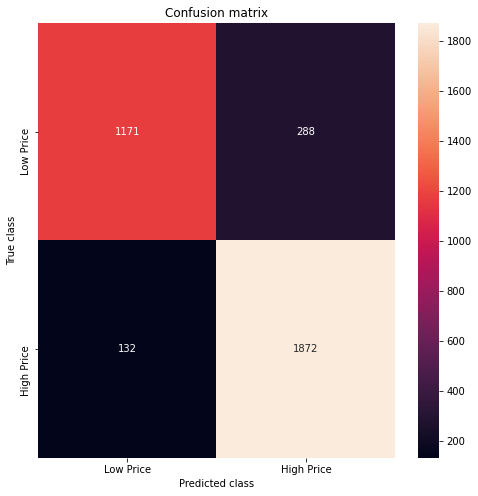

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1459
           1       0.87      0.93      0.90      2004

    accuracy                           0.88      3463
   macro avg       0.88      0.87      0.87      3463
weighted avg       0.88      0.88      0.88      3463



0.8787178746751372

In [45]:
mostrar_resultados(y_test.values, y_pred_xg)
M_XGB=f1_score(y_test.values, y_pred_xg, average='micro')
M_XGB

####  Resultados XGBoost con librería

El modelo XGBoost con librería obtiene muy buenos resultados con un **F1 SCORE** de **0.8991** y un **ACCURACY** de **0.8787** usando los parámetros sin calibrar que vienen por defecto, sin embargo el modelo mejora considerablemente en relación con **Random Forest**

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

### Grid Search
Pasamos un diccionario de parámetros a la función,luego comparamos el puntaje de validación cruzada para cada combinación de parámetros(muchos a muchos) en el diccionario y se devuelve el conjunto que tiene los mejores valores de los parámetros.
Usaremos los siguientes valores para calibrar el modelo y encontrar los mejores valores para cada parametro:

colsample_bytree: [0.3, 0.5, 0.7,0.9,1]

learning_rate: [0.01, 0.1, 0.2, 0.3]

gamma: [0.0, 0.1, 0.2, 0.3, 0.4]

### Parámetros a calibrar

**learning rate**:Es el porcentaje de cambio con el que se actualizan los pesos en cada iteración, cada vez que se realiza una iteración en el proceso de entrenamiento se deben actualizar los pesos de la entrada para poder dar cada vez una mejor aproximación.Demasiada tasa de aprendizaje conduce a la inestabilidad del aprendizaje, y un valor demasiado pequeño conduce a un tiempo de capacitación extremadamente largo. La tasa de aprendizaje adaptativo alcanza una tasa razonablemente alta bajo la premisa de garantizar un entrenamiento estable, lo que puede reducir el tiempo de entrenamiento.
El learning rate nos dice que tanto actualizamos los pesos en cada iteración, en un rango de 0 a 1.

**colsample_bytree**: Se usa para controlar la proporción del número de columnas muestreadas al azar (cada columna es una característica). Valores en un rango de 0 a 1.

**gamma**:Cuando un nodo se divide, el nodo solo se dividirá si el valor de la función de pérdida cae después de la división. Gamma especifica la caída de la función de pérdida mínima requerida para la división de nodos.
Cuanto mayor sea el valor de este parámetro, más conservador será el algoritmo. Valores de 0 a 1

In [46]:
# Parámetros usados en Grid Search
grid_search_params = {
'colsample_bytree': [0.7,0.9, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'gamma': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}
xg_grid_reg = xgb.XGBRegressor(objective= "reg:squarederror")
grid = GridSearchCV(estimator=xg_grid_reg, param_grid=grid_search_params,
scoring='neg_mean_squared_error',
cv=4, verbose=1)
grid.fit(X, y)
print("GridSearchCV")
print("Best parameters found: ", grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid.best_score_)))

Fitting 4 folds for each of 72 candidates, totalling 288 fits
GridSearchCV
Best parameters found:  {'colsample_bytree': 0.7, 'gamma': 0.5, 'learning_rate': 0.3}
Lowest RMSE found:  0.2921034538276845


In [47]:
# Modelo XGBOOST con parámetros calibrados
clf_xgb_p = XGBClassifier(colsample_bytree= 1, gamma=0.7, learning_rate=0.1)
clf_xgb_p

XGBClassifier(gamma=0.7)

In [48]:
# Entrenamiento (fit) y desempeño del modelo XGBClassifier con parámetros calibrados
clf_xgb_p.fit(X_train, y_train)
y_pred_p = clf_xgb_p.predict(X_test)
metrics.f1_score(y_pred_p, y_test.values), metrics.accuracy_score(y_pred_p, y_test.values)

(0.8995215311004784, 0.8787178746751372)

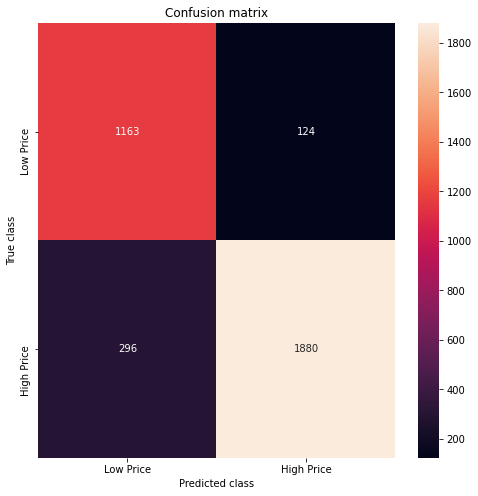

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1287
           1       0.94      0.86      0.90      2176

    accuracy                           0.88      3463
   macro avg       0.87      0.88      0.87      3463
weighted avg       0.89      0.88      0.88      3463



In [49]:
mostrar_resultados(y_pred_p, y_test.values)

#### Resultados del modelo   XGBoost con parámetros calibrados

El mejor modelo se obtiene con los siguientes parámetros calibrados:

**colsample_bytree**: 1 

**gamma**: 0.7

**learning_rate**: 0.1

Para el caso del parámetro **colsample_bytree**: 1 se obtiene el valor mas alto es decir se usan el 100% de las columnas o características para el muestreo al azar para obtener un mejor modelo.

El valor de **gamma**:0.7 es decir el modelo tiende a ser conservador en una medida moderada a alta para obtener los mejores resultados.

Para el **learning_rate**: 0.1 el mejor valor es un valor equilibrado para garantizar una tasa de entrenamiento estable y tiempo de entrenamiento moderado.

Por otra parte se mejora el **ACCURACY** levemente con respecto al modelo sin calibrar pasando de **0.8995** a **0.8787**. Para el caso del **F1 SCORE** no se observa un cambio significativo.

Es posible que calibrando otros parámetros se pueda obtener un mejor modelo, pero con los valores actuales XGBOOST representa el **ACCURACY** mas alto comparado con los modelos anteriores.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8


Los resultados obtenidos de los diferentes modelos calibrados (random forest y XGBoost) son los presentados a continuación:

| Modelo | Métrica | Resultado |
| --- | --- | --- | 
| Random Forest | F1 | 0.872653768408894 |
| Random Forest | Accuracy | 0.872653768408894 |
| XGBoost | F1 | 0.8995215311004784 |
| XGBoost | Accuracy | 0.8787178746751372 |

El modelo calibrado con mejor desempeño de los analizados fue XGBoost, obteniendo un Accuracy de 0.8787 y un F1 score de 0.8995, algunas de las ventajas de XGBoost son alta eficiencia computacional, que le permite obtener buenos resultados predictivos con poco uso de recursos, además de analizar sus falencias internas para generar cada vez un modelo más robusto y estable.

El modelo calibrado con menor desempeño de los analizados fue random forest, obteniendo un Accuracy y un F1 score de 0.872653768408894, algunas de las desventajas de random forest es su relativa poca interpretabilidad, debido a la heterogeneidad de los arboles creados, además de tener una mayor tendencia a hacer overfitting y a tener mayor inclinación a las clases mayoritarias
